# Baseline Training and Prediction Results
This notebook will provide us with a baseline for comparing the four methods of training on datasets with limited data (data augmentation, transfer learning, one-shot learning, and zero-shot learning). For the baseline model, we train using the full dataset; wherease, for the other four methods we will train only on a small-subset of the dataset.  

In [1]:
from __future__ import print_function, division

import sys
import platform
import time
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

# this is necessary to use the common functions
# assumes directory structure was maintained
sys.path.insert(0, '../common/')
# from common.torch_utils import train_model,get_device
# from torch_utils import (train_model, 
#                          mnist_dataloader, 
#                          dataset_preview)
from torch_utils import *

# print some versions
print(f'Python Version:      {platform.python_version()}')
print(f'PyTorch Version:     {torch.__version__}')
print(f'Torchvision Version: {torchvision.__version__}')
print(f'CUDA Version:        {torch.version.cuda}')

# get device (defaults to GPU if available)
device = get_device()

Python Version:      3.7.8
PyTorch Version:     1.7.1+cu101
Torchvision Version: 0.8.2+cu101
CUDA Version:        10.1

***********************************
GPU Available:  True
Current Device: cuda:0 (Tesla V100-SXM2-16GB)
***********************************



## Data Preprocessing
We need to collect the MNIST data and create the dataloaders for PyTorch. To make a clean notebook, we have created a helper function to do most of the work (refer to `/src/common/torch_utils.py`). For training the base model, we will use a batch size of 32. 

Data will be located in '../../data'
Dataset sizes: {'train': 60000, 'val': 9900, 'pred': 100}
Class names: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


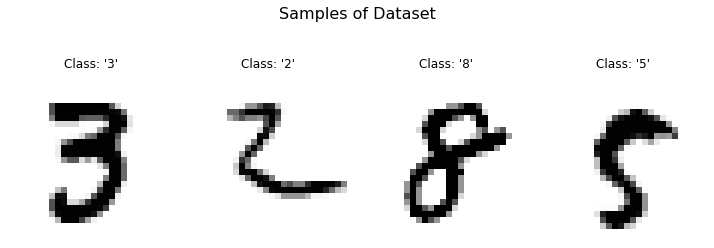

In [2]:
BATCH_SIZE = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
    ]),
}

# use helper to create the dataloaders
tmp = mnist_dataloader(data_transforms,batch_size=BATCH_SIZE,pred_size=0.01)
dataloaders, dataset_sizes, class_names = tmp 
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

# preview the dataset
dataset_preview(dataloaders['val'])

## Train the Model on the Full Dataset
For the base model we will use a ResNet, specifically the ResNet-18. The MNIST dataset is relatively small (60k training images and 10k validation images) and has only 10 output classifiers, making a larger ResNet (e.g., ResNet-50) unnecessary. Before we can use the pretrained model, however, a couple of considerations are made. First, ResNet was pretrained with the ImageNet dataset which consists of 224x224 RGB (3-channel) images; however, the MNIST dataset consists of 28x28 Grayscale (1-channel) images. The first two dimensions (HxW) are not an issue for the ResNet-18 model (we may have to retrain vs. finetune), but the third dimension discrepency will cause an error for the PyTorch model. The solution to this issue, as stated in this [reference](https://discuss.pytorch.org/t/altering-resnet18-for-single-channel-images/29198/10), is to modify the first convolutional layer changing it from `torch.nn.Conv1d(3, 64, ...)` to `torch.nn.Conv1d(1, 64, ...)` as shown in the code below.  

Second, ImageNet conists of 1000 classifications for it's labeled dataset. The MNIST dataset, as mentioned earlier, has only 10 classifications (representing handwritten numbers 0 through 10). Again, PyTorch will give a dimension mismatch error if we try to use the MNIST dataset without modifying the network. To resolve the output mismatch, we modify the output fully-connected layer with this simple line of code: `model.fc = nn.Linear(model.fc.in_features, 10)`.   

With these two modifications to the ResNet-18 netowrk, we can initiate the training process. To once again keep this notebook clean and to encourage consistent code reuse, we have put the details of the trainning process in a helper function, `train_model()`. 

In [8]:
# Use Torchvision Resnet18 for base model since our 
# dataset is small and only has 10 classes this should
# be well suited. DO NOT PRETRAIN FOR BASE MODEL.
pretrained = False
base_models = [{'name' : 'ResNet18', 'model': models.resnet18(pretrained=pretrained) }]
# model = models.resnet18(pretrained=False)

# 
output_dir='output'
num_epochs = 3
for M in base_models:
    model_name = M['name']
    model = M['model']
    # prepare the pre-trained model: 
    #   Note the following considerations given our dataset for ResNet
    #     -> MNIST data are 1-channel (grascale) of size and has 10 output classes
    #     -> ResNet model expects 3-channel (RGB) images of size 224x224 as input 
    #        and has 1000 output classes
    #     == We must changet the last fully connected layer to match 10 classes
    # keep features unchanged
    num_features = model.fc.in_features
    # change the output layer to match number of new classes
    num_classes = 10
    model.fc = nn.Linear(num_features, num_classes)
    # change the first conv layer for single channel images
    model.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=False)
    # ref: https://discuss.pytorch.org/t/altering-resnet18-for-single-channel-images/29198/10

    # move model to the GPU
    cudnn.benchmark = True

    # use helper function to train the model (outputs model and Pandas DF)
    print(f'\nTraining baseline model \'{model_name}\'...')
    model, results_df,_ = train_model(device, model, dataloaders, 
                                           dataset_sizes, output_dir=output_dir, 
                                           num_epochs=num_epochs)

    # save the data for others to use
     # <-- train_model should have created this dir
    results_file = f'{model_name}_results_{time.strftime("%Y-%m-%dT%H%M%S")}.csv'
    results_df.to_csv(os.path.join(output_dir,results_file),
                      columns=results_df.columns)
    print(f'> Saved results to \'{results_file}\'.')


Training baseline model 'ResNet18'...

Epoch 0/2
----------
train Loss: 0.6198 Acc: 0.8655
val Loss: 0.1107 Acc: 0.9665

Epoch 1/2
----------
train Loss: 0.113 Acc: 0.9657
val Loss: 0.0685 Acc: 0.9803

Epoch 2/2
----------
train Loss: 0.0779 Acc: 0.9768
val Loss: 0.0624 Acc: 0.9812
Training complete in 1.0m 23.82208752632141s
Best val Acc: 0.9812
> Saved results to 'ResNet18_results_2020-12-15T003111.csv'.


## Evaluate the Model from Full Dataset Training
During our data pre-processing (in the `mnist_dataloader()` function) we have intentionally split off 10% of the validation dataset that we can use for evaluating the model. First, notice that in 3 epochs we were able to achieve 97% accuracy using the ResNet-18 pretrained model (not bad!). Now, let's go ahead and use the `plot_classes_preds()` function from a somewhat unrealated PyTorch [tutorial](https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html) (referenece linked). The results of this function are below. 

In [ ]:
# Evaluate the model using the prediction set held-off
model.eval()
dataloader_iter = iter(dataloaders['pred'])
inputs, labels = next(dataloader_iter)
inputs = inputs.cuda()
# make predictions an plot the results
fig = plot_classes_preds(model,inputs,labels,class_names) 
plt.plot()

## Conclusion
In closing, this notebook was intended to provide us with a baseline, a "zero" if you will. I think it is pretty clear from the work in this notebook that the ResNet-18 is a reasonable target model to finetune as a classifier for the MNIST dataset. Now, let's see how other methods can compare when dealing with a limited dataset for training.

## References:
[1] https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html